In [1]:
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import corner
import json

import pytensor
from pytensor import tensor as pt
from pytensor.graph.basic import Apply

from pytensor.graph import Apply, Op
from pytensor.tensor.type import TensorType

import jax
from jax import grad, jit, vmap, value_and_grad, random
import jax.numpy as jnp

import pyhf
pyhf.set_backend('jax')
# pyhf.set_backend('numpy')

import pymc as pm
import arviz as az

from pyhf_pymc import prepare_inference


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
RANDOM_SEED = 915623497
np.random.seed(RANDOM_SEED)

## Model

In [3]:
N = 3
nBins = N
obs = jnp.array([70.]*N)
model = pyhf.simplemodels.correlated_background([10]*N,[50]*N,[45]*N,[45]*N)

n_samples = 100_000

unconstr_dict = {
    'mu': {'type': 'unconstrained', 'input': [[5.], [1.]]}
}
prior_dict = prepare_inference.prepare_priors(model, unconstr_dict)
precision = []
[precision.append(float(obs[i])**(0.5)) for i in range(nBins)]
prepared_model = prepare_inference.prepare_model(model=model, observations=obs, precision=precision, priors=prior_dict)

In [2]:
### Simple pyhf model
model = pyhf.Model(
    {'channels': [{'name': 'singlechannel',
    'samples': [
    {'name': 'signal',
     'data': [6, 6, 10, 5],
     'modifiers': [
         {'name': 'mu', 'type': 'normfactor', 'data': None},
        #  {'name': 'mu1', 'type': 'normfactor', 'data': None}
        ]},

    {'name': 'background',
     'data': [450, 550, 650, 650]
     ,
     'modifiers': [
        ## Staterror / Normal
        {"name": "my_staterror","type": "staterror","data": [100.0, 200.0, 200.0, 200.0],},
        ## Lumi / Normal
        # {'name': 'lumi', 'type': 'lumi', 'data': None},
        ## Correlated / Normal
        {'name': 'corr_bkg', 'type': 'histosys','data': {'hi_data': [652, 662, 702, 702], 'lo_data': [650, 660, 700, 700]}},
        # ## Uncorrelated / Poisson
        {'name': 'uncorr_bkg', 'type': 'shapesys','data': [7, 8, 7.17, 7.17]},
        
         ]
         },    
                                 
    ]},
    ]
    ,
    "parameters": [
            {
                "name": "lumi",
                "auxdata": [1.0],
                "sigmas": [0.017],
                "bounds": [[0.915, 1.085]],
                "inits": [1.0],
            }],
        }
)

obs = model.expected_actualdata(model.config.suggested_init())

nBins = len(model.expected_actualdata(model.config.suggested_init()))
nPars = len(model.config.suggested_init())

# Prepare the priors for sampling
    # Unconstrained parameters
unconstr_dict = {}
unconstr_dict = {
    'uncon0': {'type': 'unconstrained', 'type2': 'normal', 'input': [[2.], [1.]]},
    # 'uncon1': {'type': 'unconstrained', 'type2': 'normal', 'input': [[2], [1]]}
    }

    # Create dictionary with all priors (unconstrained, constrained by normal and poisson)
prior_dict = prepare_inference.prepare_priors(model, unconstr_dict)


    # dictionary with keys 'model', 'obs', 'priors', 'precision'
precision = []
[precision.append(float(obs[i])**(0.5)) for i in range(nBins)]
prepared_model = prepare_inference.prepare_model(model=model, observations=obs, precision=precision, priors=prior_dict)

In [2]:
# with open('SRee_SRmm_Srem.json') as serialized:
with open('ttbar_ljets_xsec_inclusive_pruned.json') as serialized:
    spec = json.load(serialized)

workspace = pyhf.Workspace(spec)
model = workspace.model()

obs = workspace.data(model, include_auxdata=False)

nBins = len(model.expected_actualdata(model.config.suggested_init()))
nPars = len(model.config.suggested_init())

# Prepare the priors for sampling
    # Unconstrained parameters
unconstr_dict = {
    'uncon1': {'type': 'unconstrained', 'type2': 'normal', 'input': [[2.], [1.]]}
    }

    # Create dictionary with all priors (unconstrained, constrained by normal and poisson)
prior_dict = prepare_inference.prepare_priors(model, unconstr_dict)

    # dictionary with keys 'model', 'obs', 'priors', 'precision'
precision = []
[precision.append(float(obs[i])**(0.5)) for i in range(nBins)]
prepared_model = prepare_inference.prepare_model(model=model, observations=obs, precision=precision, priors=prior_dict)

NameError: name 'json' is not defined

## General functions

In [4]:
# Jax expected data
@jax.jit
def processed_expData(parameters):
    return model.expected_actualdata(parameters)

jitted_processed_expData = jax.jit(processed_expData)

# Gradient list (dn_bins/dx_1, ..., dn_bins/dx_nPars)
@jax.jit
def vjp_expData(pars, tang_vec):
    _, back = jax.vjp(processed_expData, pars)
    return back(tang_vec)[0]

jitted_vjp_expData = jax.jit(vjp_expData)

## Op Class

#### Gradient Op

In [5]:
class VJPOp(Op):

    itypes = [pt.dvector,pt.dvector]  
    otypes = [pt.dvector]

    def perform(self, node, inputs, outputs):
        (parameters, tangent_vector) = inputs
        results = jitted_vjp_expData(parameters, tangent_vector)

        # if not isinstance(results, (list, tuple)):
        #         results = (results,)
                
        # for i, r in enumerate(results):
        #     outputs[i][0] = np.asarray(r)
        outputs[0][0] = np.asarray(results)

vjp_op = VJPOp()

#### Non Gradient Op

In [6]:
class ExpDataOp(Op):

    itypes = [pt.dvector]  
    otypes = [pt.dvector]

    def perform(self, node, inputs, outputs):
        (parameters, ) = inputs
        results = jitted_processed_expData(parameters)

        # if len(outputs) == 1:
        #         outputs[0][0] = np.asarray(results)
        #         retinitn
        # for i, r in enumerate(results):
        #         outputs[i][0] = np.asarray(r)
        outputs[0][0] = np.asarray(results)

    def grad(self, inputs, output_gradients):
        (parameters,) = inputs
        (tangent_vector,) = output_gradients
        return [vjp_op(parameters, tangent_vector)]
        
expData_op = ExpDataOp()

## Sampling

#### Metropolis

In [7]:
# %%timeit 
with pm.Model(coords={"bin": [1, 2, 3]}) as m:
    
    # pars = pm.Deterministic('pars', prepare_inference.priors2pymc(prepared_model))
    pars = prepare_inference.priors2pymc(prepared_model)
    # ExpData_Det = pm.Deterministic('ExpData_Det', expData_op(pars))

    ExpData = pm.Poisson("ExpData", mu=expData_op(pars), observed=obs, dims='bin')
    # ExpData = pm.Normal("ExpData", mu=expData_op(pars), sigma = precision, observed=obs)
    
    step1 = pm.Metropolis()
    # step2 = pm.NUTS()
    # step3 = pm.HamiltonianMC()
    
    post_data = pm.sample(draws=10_000, chains = 1, cores=4, step=step1, progressbar=True, random_seed=RANDOM_SEED)
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(10_000)

Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 1 seconds.


Sampling: [ExpData, Normals, Unconstrained]


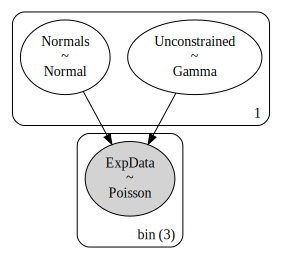

In [15]:
pm.model_to_graphviz(m)

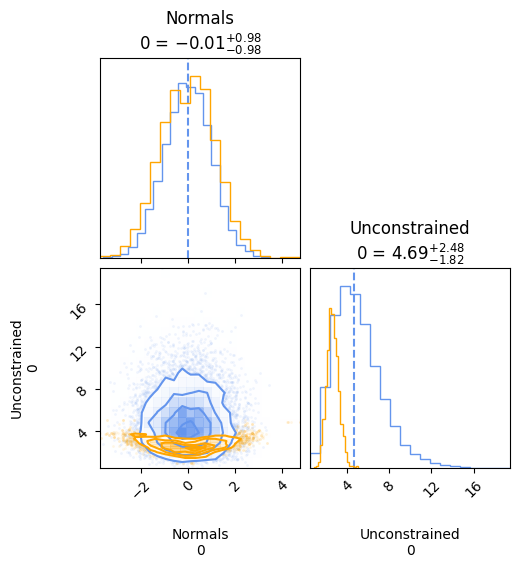

In [8]:
# Parameter Corner Plots
a = corner.corner(prior_pred.prior, quantiles=[0.5], show_titles=True, color='cornflowerblue')
corner.corner(post_data.posterior, color = 'orange', fig=a);

#### NUTS

In [9]:
# %%timeit
with pm.Model() as m1:
    pars = prepare_inference.priors2pymc(prepared_model)
    # ExpData_Det = pm.Deterministic('ExpData_Det', expData_op(pars))

    ExpData = pm.Poisson("ExpData", mu=expData_op(pars), observed=obs)
    # ExpData = pm.Normal("ExpData", mu=expData_op(pars), sigma = precision, observed=obs)

    step1 = pm.Metropolis()

    post_data_NUTS = pm.sample(draws=1000, chains=1, cores=4, random_seed=RANDOM_SEED)
    post_pred_NUTS = pm.sample_posterior_predictive(post_data_NUTS)
    prior_pred_NUTS = pm.sample_prior_predictive(100_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1 seconds.
/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/arviz/data/base.py:221: UserWarning: More chains (1000) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


Sampling: [ExpData, Normals, Unconstrained]


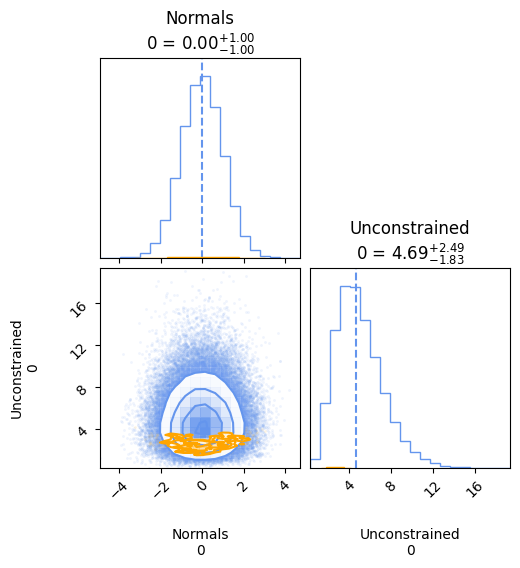

In [10]:
# Parameter Corner Plots
a = corner.corner(prior_pred_NUTS.prior, quantiles=[0.5], show_titles=True, color='cornflowerblue')
corner.corner(post_data_NUTS.posterior, color = 'orange', fig=a);

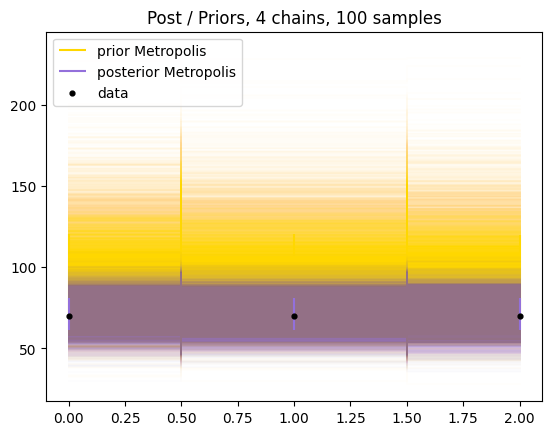

In [8]:
# Prior
# plt.step(np.linspace(0,nBins-1,nBins),prior_pred_NUTS.prior_predictive.ExpData[0].T, alpha = 0.01, c = 'lightcoral', where = 'mid');
# plt.vlines(np.arange(nBins),*np.quantile(prior_pred_NUTS.prior_predictive.ExpData[0],[.15,.85],axis=0), colors = 'lightcoral', label='prior NUTS with advi');

plt.step(np.linspace(0,nBins-1,nBins),prior_pred.prior_predictive.ExpData[0].T, alpha = 0.01, c = 'gold', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred.prior_predictive.ExpData[0],[.15,.85],axis=0), colors = 'gold', label='prior Metropolis');

# # Posterior
# plt.step(np.linspace(0,nBins-1,nBins),post_pred_NUTS.posterior_predictive.ExpData[0].T, alpha = 0.01, c = 'cornflowerblue', where = 'mid');
# plt.vlines(np.arange(nBins),*np.quantile(post_pred_NUTS.posterior_predictive.ExpData[0],[.15,.85],axis=0), colors = 'cornflowerblue', label='posterior NUTS with advi')

plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.ExpData[0].T, alpha = 0.01, c = 'mediumpurple', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.ExpData[0],[.15,.85],axis=0), colors = 'mediumpurple', label='posterior Metropolis')


# Observations
plt.scatter(np.arange(nBins), obs, c = 'k',s=12, zorder = 999, label = "data")
plt.legend(loc='upper left')

plt.title(f'Post / Priors, 4 chains, 100 samples')

# plt.savefig('Metropolis_adviNUsS_ttbar')
plt.show()

array([[<AxesSubplot: title={'center': 'Normals'}>,
        <AxesSubplot: title={'center': 'Normals'}>]], dtype=object)

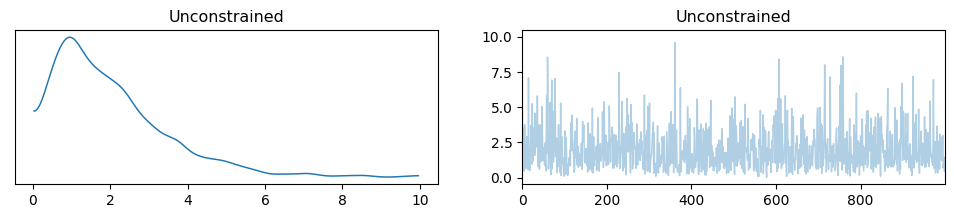

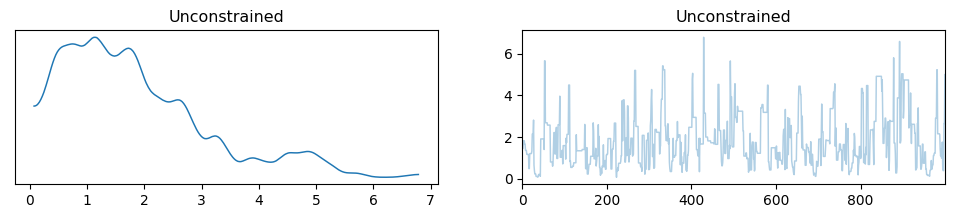

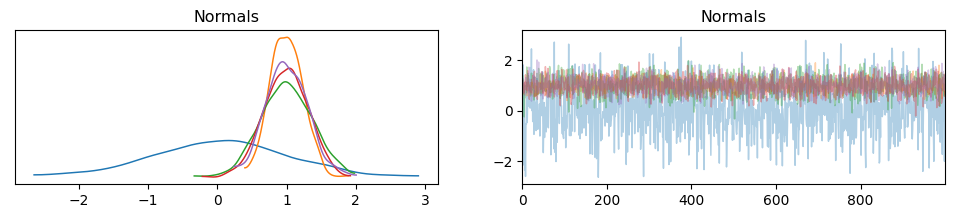

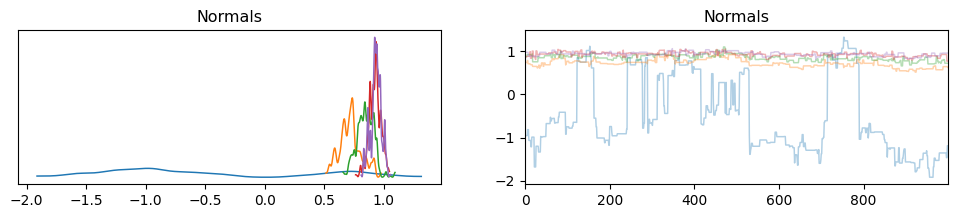

In [27]:
az.plot_trace(prior_pred.prior, var_names='Unconstrained')
az.plot_trace(post_data.posterior, var_names='Unconstrained')

az.plot_trace(prior_pred.prior, var_names='Normals')
az.plot_trace(post_data.posterior, var_names='Normals')

array([[<AxesSubplot: title={'center': 'Normals'}>,
        <AxesSubplot: title={'center': 'Normals'}>]], dtype=object)

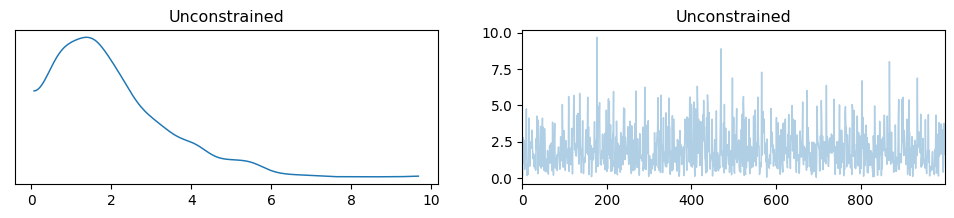

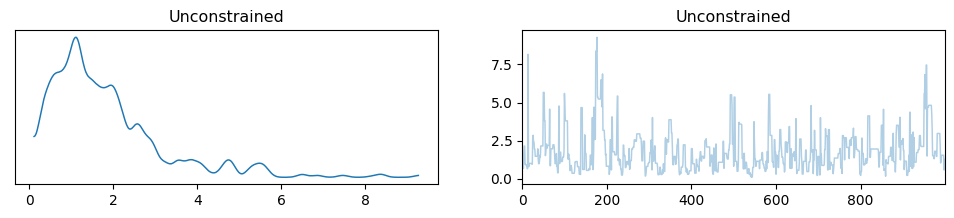

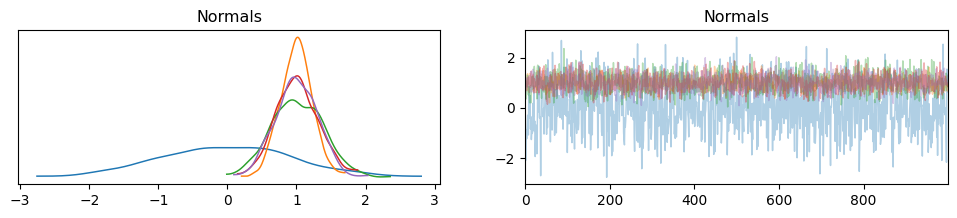

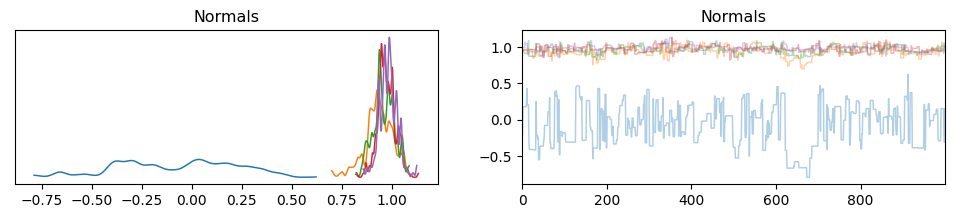

In [28]:
az.plot_trace(prior_pred_NUTS.prior, var_names='Unconstrained')
az.plot_trace(post_data_NUTS.posterior, var_names='Unconstrained')

az.plot_trace(prior_pred_NUTS.prior, var_names='Normals')
az.plot_trace(post_data_NUTS.posterior, var_names='Normals')

In [ ]:
fig = corner.corner(prior_pred.prior.Normals[0], hist_kwargs={'density': True}, color='green');
fig = corner.corner(post_data.posterior.Normals[0], fig = fig, color = 'steelblue', hist_kwargs={'density': True});

## Convergence check posterior for the predictions

In [19]:
N = 5
nBins = N
init_obs = jnp.array([70., 70., 90., 90., 80.])
model = pyhf.simplemodels.correlated_background([10]*N,[50]*N, [45]*N, [55]*N)
model.expected_actualdata(model.config.suggested_init()),model.config.suggested_init()

n_samples = 1000

unconstr_dict = {
    'mu': {'type': 'unconstrained', 'input': [[5.], [1.]]}
}
prior_dict = prepare_inference.prepare_priors(model, unconstr_dict)
prepared_model = prepare_inference.prepare_model(model=model, observations=init_obs, precision=8, priors=prior_dict)

#### First inference

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.
INFO:pymc:Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.
INFO:pymc:Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]
INFO:pymc:Sampling: [ExpData1, Normals, Unconstrained]


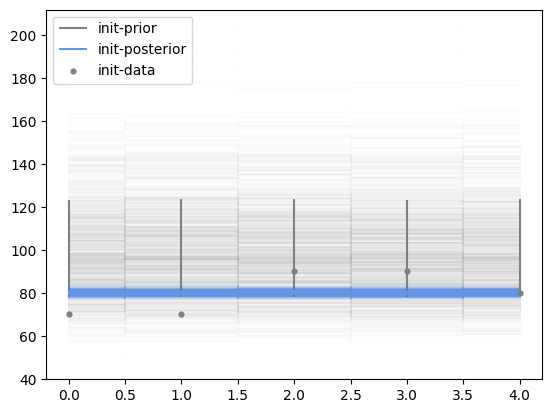

In [23]:
# init prior and posteriors
with pm.Model() as m1:
    # pars1 = pm.Deterministic('pars1', prepare_inference.priors2pymc(prepared_model))
    pars1 = prepare_inference.priors2pymc(prepared_model)
    # ExpData_Det1 = pm.Deterministic('ExpData_Det1', expData_op(pars1))

    ExpData1 = pm.Normal("ExpData1", mu=expData_op(pars1), sigma = 1, observed=init_obs)
    
    step1 = pm.Metropolis()
    
    post_data_init = pm.sample(n_samples, chains=1, cores=4, init='advi')
    post_pred_init = pm.sample_posterior_predictive(post_data_init)
    prior_pred_init = pm.sample_prior_predictive(n_samples)

# init Prior
plt.step(np.linspace(0,nBins-1,nBins),prior_pred_init.prior_predictive.ExpData1[0].T, alpha = 0.01, c = 'grey', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred_init.prior_predictive.ExpData1[0],[.15,.85],axis=0), colors = 'grey', label='init-prior');

# init Posterior
plt.step(np.linspace(0,nBins-1,nBins),post_pred_init.posterior_predictive.ExpData1[0].T, alpha = 0.01, c = 'cornflowerblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred_init.posterior_predictive.ExpData1[0],[.15,.85],axis=0), colors = 'cornflowerblue', label='init-posterior')

# Observations
plt.scatter(np.arange(nBins), init_obs, c = 'grey', s=12, zorder = 999, label = "init-data")


plt.legend(loc='upper left')

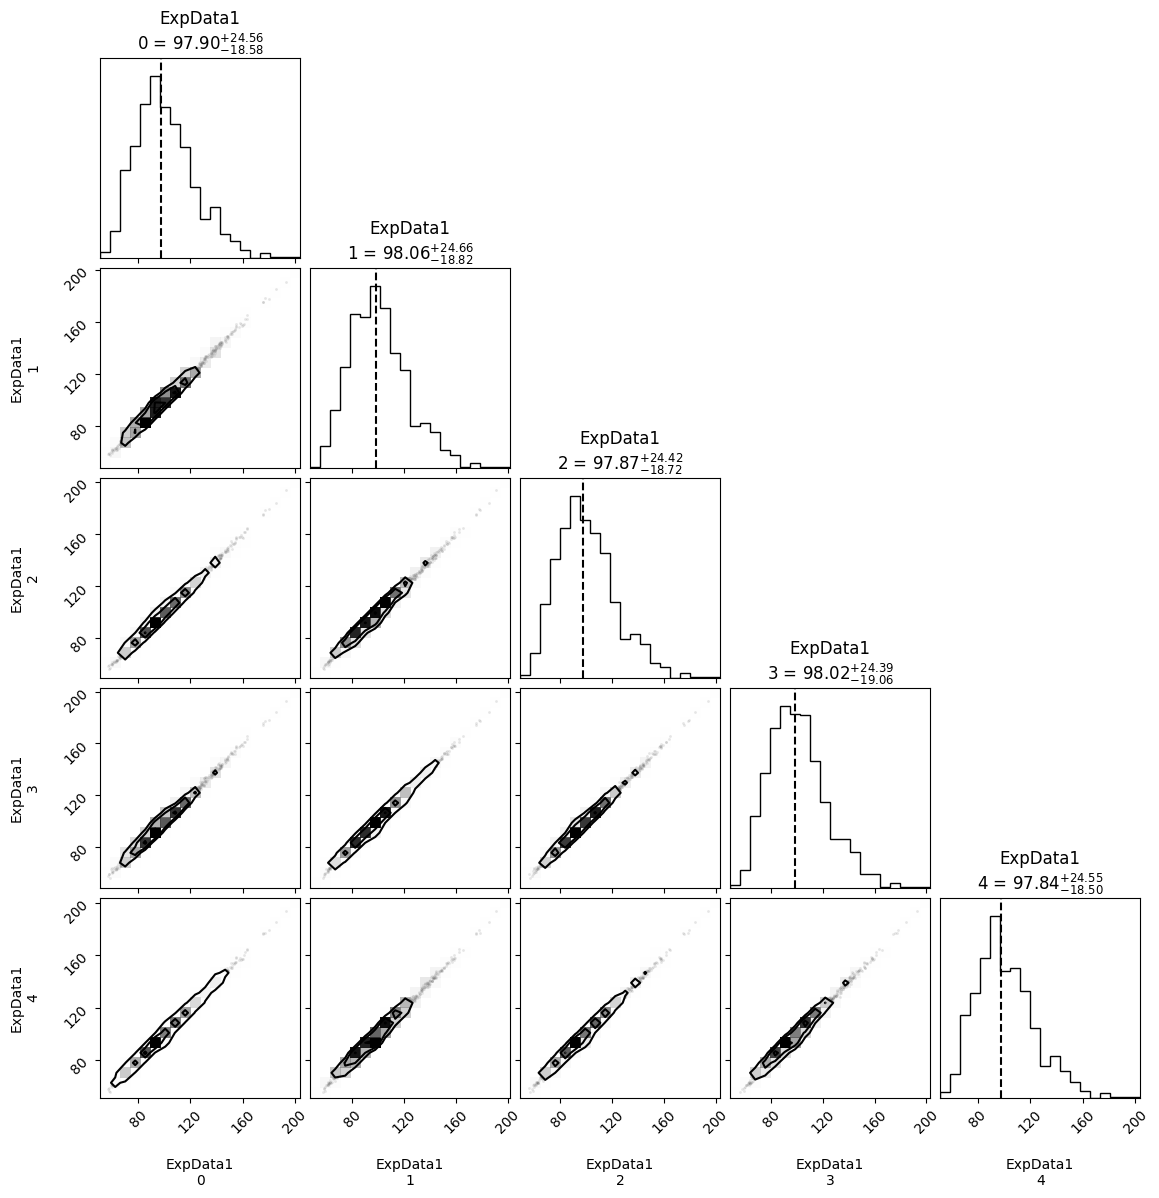

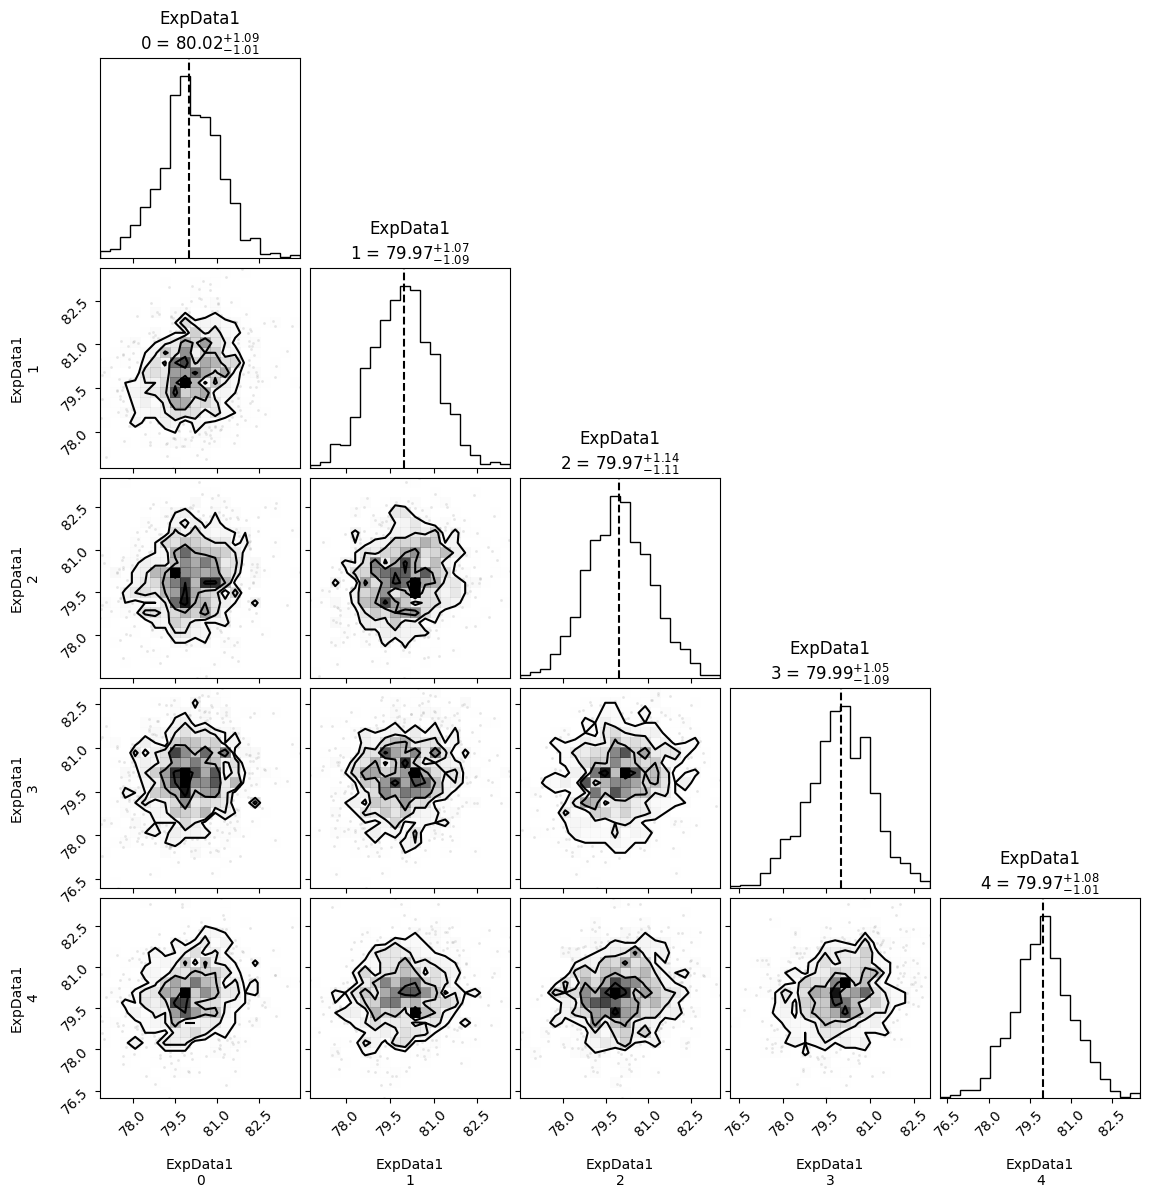

In [24]:
a = corner.corner(prior_pred_init.prior_predictive, quantiles=[0.5], show_titles=True)
b = corner.corner(post_pred_init.posterior_predictive, quantiles=[0.5], show_titles=True)

#### Iterative inference

In [ ]:
obs_from_prior = init_obs

n_samples = 100
n_iterations = 2

post = []
post_average_iters = []

for iterations in np.linspace(1, 15, n_iterations, dtype=int):
    obs_from_prior = init_obs
    print(f'ITERATION: {iterations}')
    for i in range(iterations):
        with pm.Model() as m1:
            # pars1 = pm.Deterministic('pars1', prepare_inference.priors2pymc(prepared_model))
            pars1 = prepare_inference.priors2pymc(prepared_model)
            
            # ExpData_Det1 = pm.Deterministic('ExpData_Det1', expData_op(pars1))
            ExpData1 = pm.Normal("ExpData1", mu=expData_op(pars1), sigma = 8, observed=obs_from_prior)
            
            step1 = pm.Metropolis()
            
            post_data = pm.sample(n_samples, chains=1, cores=4, step=step1)
            post_pred = pm.sample_posterior_predictive(post_data)
            prior_pred = pm.sample_prior_predictive(n_samples)

            post.append(post_pred.posterior_predictive.ExpData1[0])

            ii = randint(0, n_samples - 1)
            print(f'ii: {ii} for i: {i}')
            obs_from_prior = prior_pred.prior_predictive.ExpData1[0][ii] 
        
    post_average = []
    for i in range(nBins):
        aa = 0
        for b in range(n_samples):
            for a in range(iterations):
                aa = aa + post[a][b][i]
        post_average.append(aa/(n_samples*iterations))

    post_average_iters.append(np.asarray(post_average))


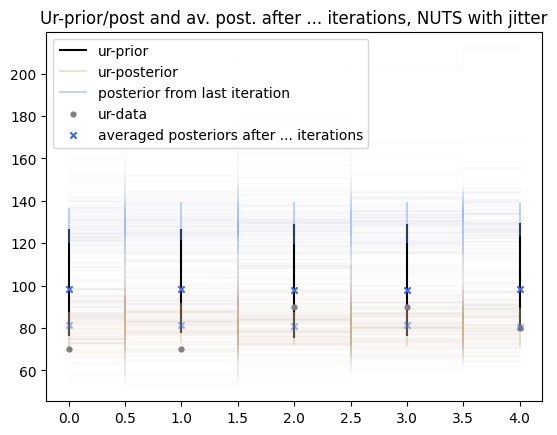

In [115]:
# init Prior
plt.step(np.linspace(0,nBins-1,nBins),prior_pred_init.prior_predictive.ExpData1[0].T, alpha = 0.01, c = 'black', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred_init.prior_predictive.ExpData1[0],[.15,.85],axis=0), colors = 'black', label='init-prior');

# init Posterior
plt.step(np.linspace(0,nBins-1,nBins),post_pred_init.posterior_predictive.ExpData1[0].T, alpha = 0.02, c = 'tan', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred_init.posterior_predictive.ExpData1[0],[.15,.85],axis=0), alpha = 0.4, colors = 'tan', label='init-posterior')

# Posterior from last iteration
plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.ExpData1[0].T, alpha = 0.01, c = 'cornflowerblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.ExpData1[0],[.15,.85],axis=0),colors = 'cornflowerblue', alpha=0.4, label='posterior from last iteration')

# Observations
plt.scatter(np.arange(nBins), init_obs, c = 'grey', s=12, zorder = 999, label = "init-data")

# Average posterior
plt.scatter(np.arange(nBins), post_average_iters[n_iterations-1], c = 'royalblue', s=20, marker='x', zorder = 999, alpha = 1, label = 'averaged posteriors after ... iterations')
for i in range(n_iterations-1):
    plt.scatter(np.arange(nBins), post_average_iters[i], c = 'royalblue', s=20, marker='x', zorder = 999, alpha = i/1000+0.5)

plt.legend(loc='upper left')
plt.title(f'init-prior/post and av. post. after ... iterations, NUTS with jitter')

# plt.savefig('Metropolis_1_and_100_iterations.pdf')
plt.show()

## Convergence check posterior with Corner Plots

In [11]:
N = 3
nBins = N
init_obs = jnp.array([70., 60., 60.])# 90., 90., 80.])
model = pyhf.simplemodels.correlated_background([10]*N,[50]*N, [45]*N, [55]*N)
model.expected_actualdata(model.config.suggested_init()),model.config.suggested_init()

n_samples = 1000

unconstr_dict = {
    'mu': {'type': 'unconstrained', 'input': [[5000.], [1000.]]}
}
prior_dict = prepare_inference.prepare_priors(model, unconstr_dict)
prepared_model = prepare_inference.prepare_model(model=model, observations=init_obs, precision=4, priors=prior_dict)

#### init inference

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


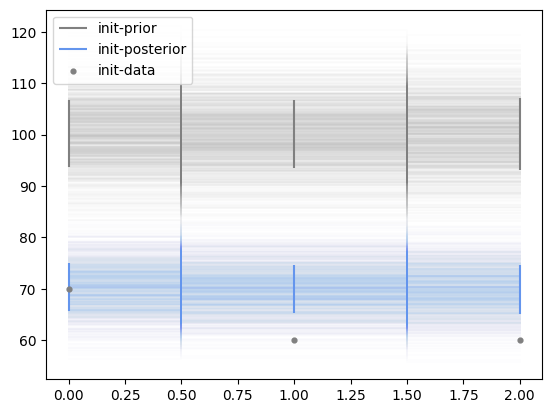

In [12]:
# init prior and posteriors
with pm.Model() as m1:
    # pars1 = pm.Deterministic('pars1', prepare_inference.priors2pymc(prepared_model))
    pars1 = prepare_inference.priors2pymc(prepared_model)
    # ExpData_Det1 = pm.Deterministic('ExpData_Det1', expData_op(pars1))

    ExpData1 = pm.Normal("ExpData1", mu=expData_op(pars1), sigma = 4, observed=init_obs)
    
    step1 = pm.Metropolis()
    
    post_data_init = pm.sample(n_samples, chains=1, cores=4, init='advi')
    post_pred_init = pm.sample_posterior_predictive(post_data_init)
    prior_pred_init = pm.sample_prior_predictive(n_samples)

# init Prior
plt.step(np.linspace(0,nBins-1,nBins),prior_pred_init.prior_predictive.ExpData1[0].T, alpha = 0.01, c = 'grey', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred_init.prior_predictive.ExpData1[0],[.15,.85],axis=0), colors = 'grey', label='init-prior');

# init Posterior
plt.step(np.linspace(0,nBins-1,nBins),post_pred_init.posterior_predictive.ExpData1[0].T, alpha = 0.01, c = 'cornflowerblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred_init.posterior_predictive.ExpData1[0],[.15,.85],axis=0), colors = 'cornflowerblue', label='init-posterior')

# Observations
plt.scatter(np.arange(nBins), init_obs, c = 'grey', s=12, zorder = 999, label = "init-data")


plt.legend(loc='upper left')

In [ ]:
a = corner.corner(prior_pred_init.prior, quantiles=[0.5], show_titles=True)
b = corner.corner(post_data_init.posterior, quantiles=[0.5], show_titles=True)

In [ ]:
a = corner.corner(prior_pred_init.prior_predictive, quantiles=[0.5], show_titles=True)
b = corner.corner(post_pred_init.posterior_predictive, quantiles=[0.5], show_titles=True)

#### Iterative inference with averaging

In [ ]:
obs_from_prior = init_obs

n_samples = 100
n_iterations = 3

post = []
post_average_iters = []

for iterations in np.linspace(1, 15, n_iterations, dtype=int):
    obs_from_prior = init_obs
    print(f'ITERATION: {iterations}')
    for i in range(iterations):
        with pm.Model() as m1:
            # pars1 = pm.Deterministic('pars1', prepare_inference.priors2pymc(prepared_model))
            pars1 = prepare_inference.priors2pymc(prepared_model)
            
            # ExpData_Det1 = pm.Deterministic('ExpData_Det1', expData_op(pars1))
            ExpData1 = pm.Normal("ExpData1", mu=expData_op(pars1), sigma = 8, observed=obs_from_prior)
            
            step1 = pm.Metropolis()
            
            post_data = pm.sample(n_samples, chains=1, cores=4)#, step=step1)
            post_pred = pm.sample_posterior_predictive(post_data)
            prior_pred = pm.sample_prior_predictive(n_samples)

            post.append(post_pred.posterior_predictive.ExpData1[0])

            ii = randint(0, n_samples - 1)
            print(f'ii: {ii} for i: {i}')
            obs_from_prior = prior_pred.prior_predictive.ExpData1[0][ii] 
        
    post_average = []
    for i in range(nBins):
        aa = 0
        for b in range(n_samples):
            for a in range(iterations):
                aa = aa + post[a][b][i]
        post_average.append(aa/(n_samples*iterations))

    post_average_iters.append(np.asarray(post_average))


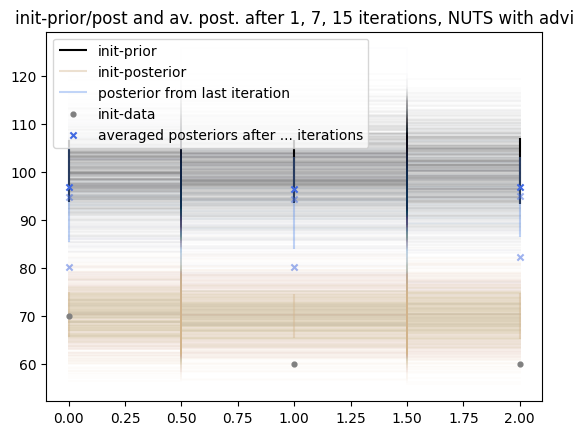

In [21]:
# init Prior
plt.step(np.linspace(0,nBins-1,nBins),prior_pred_init.prior_predictive.ExpData1[0].T, alpha = 0.01, c = 'black', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred_init.prior_predictive.ExpData1[0],[.15,.85],axis=0), colors = 'black', label='init-prior');

# init Posterior
plt.step(np.linspace(0,nBins-1,nBins),post_pred_init.posterior_predictive.ExpData1[0].T, alpha = 0.02, c = 'tan', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred_init.posterior_predictive.ExpData1[0],[.15,.85],axis=0), alpha = 0.4, colors = 'tan', label='init-posterior')

# Posterior from last iteration
plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.ExpData1[0].T, alpha = 0.01, c = 'cornflowerblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.ExpData1[0],[.15,.85],axis=0),colors = 'cornflowerblue', alpha=0.4, label='posterior from last iteration')

# Observations
plt.scatter(np.arange(nBins), init_obs, c = 'grey', s=12, zorder = 999, label = "init-data")

# Average posterior
plt.scatter(np.arange(nBins), post_average_iters[n_iterations-1], c = 'royalblue', s=20, marker='x', zorder = 999, alpha = 1, label = 'averaged posteriors after ... iterations')
for i in range(n_iterations-1):
    plt.scatter(np.arange(nBins), post_average_iters[i], c = 'royalblue', s=20, marker='x', zorder = 999, alpha = i/1000+0.5)

plt.legend(loc='upper left')
plt.title(f'init-prior/post and av. post. after 1, 7, 15 iterations, NUTS with advi')

# plt.savefig('Metropolis_1_and_100_iterations.pdf')
plt.show()

#### Iterative inference without averaging

In [79]:
obs_from_prior = init_obs
iterations = 2
post = []

for i in range(iterations):
    with pm.Model() as m1:
        pars1 = prepare_inference.priors2pymc(prepared_model)

        ExpData1 = pm.Normal("ExpData1", mu=expData_op(pars1), sigma = 4, observed=obs_from_prior)
        
        step1 = pm.Metropolis()
        
        post_data_2 = pm.sample(n_samples, chains=1, cores=4, step=step1)
        post_pred_2 = pm.sample_posterior_predictive(post_data_2)
        prior_pred_2 = pm.sample_prior_predictive(n_samples)

        post.append(post_pred.posterior_predictive.ExpData1[0])

        ii = randint(0, n_samples - 1)
        print(f'ii: {ii} for i: {i}')
        obs_from_prior = prior_pred.prior_predictive.ExpData1[0][ii] 

Only 100 samples in chain.


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 84 for i: 0


Only 100 samples in chain.


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 70 for i: 1


In [62]:
post_pred_1.posterior_predictive.ExpData1[0][20][2]

<xarray.DataArray 'ExpData1' ()>
array(72.78872109)
Coordinates:
    chain           int64 0
    draw            int64 20
    ExpData1_dim_2  int64 2

In [80]:
post_average_1 = []
aa = 0
for i in range(nBins):
    aa = 0
    for ii in range(n_samples):
        # print(post_pred_1.posterior_predictive.ExpData1[0][ii][i])
        aa = aa + post_pred_1.posterior_predictive.ExpData1[0][ii][i]
    post_average_1.append(aa/n_samples)

post_average_2 = []
aa = 0
for i in range(nBins):
    aa = 0
    for ii in range(n_samples):
        # print(post_pred_1.posterior_predictive.ExpData1[0][ii][i])
        aa = aa + post_pred_2.posterior_predictive.ExpData1[0][ii][i]
    post_average_2.append(aa/n_samples)


post_average_3 = []
aa = 0
for i in range(nBins):
    aa = 0
    for ii in range(n_samples):
        # print(post_pred_1.posterior_predictive.ExpData1[0][ii][i])
        aa = aa + post_pred_3.posterior_predictive.ExpData1[0][ii][i]
    post_average_3.append(aa/n_samples)

post_average_10 = []
aa = 0
for i in range(nBins):
    aa = 0
    for ii in range(n_samples):
        # print(post_pred_1.posterior_predictive.ExpData1[0][ii][i])
        aa = aa + post_pred_10.posterior_predictive.ExpData1[0][ii][i]
    post_average_10.append(aa/n_samples)


post_average_15 = []
aa = 0
for i in range(nBins):
    aa = 0
    for ii in range(n_samples):
        # print(post_pred_1.posterior_predictive.ExpData1[0][ii][i])
        aa = aa + post_pred_15.posterior_predictive.ExpData1[0][ii][i]
    post_average_15.append(aa/n_samples)

post_average_20 = []
aa = 0
for i in range(nBins):
    aa = 0
    for ii in range(n_samples):
        # print(post_pred_1.posterior_predictive.ExpData1[0][ii][i])
        aa = aa + post_pred_20.posterior_predictive.ExpData1[0][ii][i]
    post_average_20.append(aa/n_samples)

print(np.asarray(post_average_1))
print(np.asarray(post_average_3))
print(np.asarray(post_average_10))
print(np.asarray(post_average_15))
print(np.asarray(post_average_20))


[69.8469248  69.1369342  70.08143783]
[104.4381264  104.46526213 104.20142341]
[92.87185935 93.26483835 92.30213925]
[103.9924047  103.00087175 103.69225158]
[101.56137804 101.69948907 101.65237718]


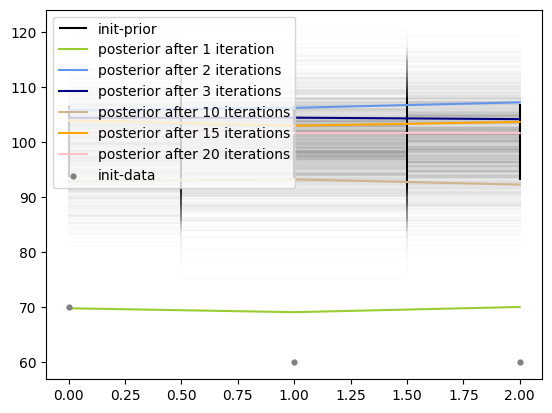

In [87]:

# init Prior
plt.step(np.linspace(0,nBins-1,nBins),prior_pred_init.prior_predictive.ExpData1[0].T, alpha = 0.01, c = 'black', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred_init.prior_predictive.ExpData1[0],[.15,.85],axis=0), colors = 'black', label='init-prior');

# iiterative Prior
# plt.step(np.linspace(0,nBins-1,nBins),prior_pred_1.prior_predictive.ExpData1[0].T, alpha = 0.01, c = 'green', where = 'mid');
# plt.vlines(np.arange(nBins),*np.quantile(prior_pred_1.prior_predictive.ExpData1[0],[.15,.85],axis=0), colors = 'green', label='prior after 1 iteration');

plt.plot(np.arange(nBins), post_average_1, color = 'yellowgreen', label='posterior after 1 iteration')
plt.plot(np.arange(nBins), post_average_2, color = 'cornflowerblue', label='posterior after 2 iterations')
plt.plot(np.arange(nBins), post_average_3, color = 'navy', label='posterior after 3 iterations')
plt.plot(np.arange(nBins), post_average_10, color = 'tan', label='posterior after 10 iterations')
plt.plot(np.arange(nBins), post_average_15, color = 'orange', label='posterior after 15 iterations')
plt.plot(np.arange(nBins), post_average_20, color = 'pink', label='posterior after 20 iterations')


# Observations
plt.scatter(np.arange(nBins), init_obs, c = 'grey', s=12, zorder = 999, label = "init-data")


plt.legend(loc='upper left')

#### Average and get prior

In [37]:
N = 3
nBins = N
init_obs = jnp.array([70., 60., 60.])# 90., 90., 80.])
model = pyhf.simplemodels.correlated_background([10]*N,[50]*N, [45]*N, [55]*N)
model.expected_actualdata(model.config.suggested_init()),model.config.suggested_init()

n_samples = 1000

unconstr_dict = {
    'mu': {'type': 'unconstrained', 'input': [[5000.], [1000.]]}
}
prior_dict = prepare_inference.prepare_priors(model, unconstr_dict)
prepared_model = prepare_inference.prepare_model(model=model, observations=init_obs, precision=4, priors=prior_dict)

In [42]:
# init prior and posteriors
with pm.Model() as m1:
    # pars1 = pm.Deterministic('pars1', prepare_inference.priors2pymc(prepared_model))
    pars1 = prepare_inference.priors2pymc(prepared_model)
    # ExpData_Det1 = pm.Deterministic('ExpData_Det1', expData_op(pars1))

    ExpData1 = pm.Normal("ExpData1", mu=expData_op(pars1), sigma = 4, observed=init_obs)
    
    step1 = pm.Metropolis()
    
    post_data_init = pm.sample(n_samples, chains=1, cores=4, init='advi')
    post_pred_init = pm.sample_posterior_predictive(post_data_init)
    prior_pred_init = pm.sample_prior_predictive(n_samples)


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


In [149]:
obs_from_prior = init_obs
iterations = 500
post = []
post_exp = []


for i in range(iterations):
    with pm.Model() as m1:
        pars1 = prepare_inference.priors2pymc(prepared_model)

        ExpData1 = pm.Normal("ExpData1", mu=expData_op(pars1), sigma = 4, observed=obs_from_prior)
        
        step1 = pm.Metropolis()
        
        post_data = pm.sample(n_samples, chains=1, cores=4)#, init='advi')#
        post_pred = pm.sample_posterior_predictive(post_data)
        prior_pred = pm.sample_prior_predictive(n_samples)

        post.append(post_pred.posterior_predictive.ExpData1[0])

        ii = randint(0, n_samples - 1)
        print(f'ii: {ii} for i: {i}')
        obs_from_prior = prior_pred.prior_predictive.ExpData1[0][ii] 

    post.append(post_pred.posterior_predictive)
    post_exp.append(np.asarray(post_pred.posterior_predictive.ExpData1[0]))

# post = np.asarray(post)
print(len(post))

post_averages = []

for i in range(iterations):
    iter_ = []
    for b in range(nBins):
        aa = 0
        for ii in range(n_samples):
            aa = aa + post_exp[i][ii][b]
        iter_.append(aa/n_samples)
    post_averages.append(iter_)

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 990 for i: 0


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 13 for i: 1


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 465 for i: 2


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 862 for i: 3


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 946 for i: 4


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 899 for i: 5


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 763 for i: 6


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 199 for i: 7


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 211 for i: 8


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 292 for i: 9


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 787 for i: 10


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 413 for i: 11


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 761 for i: 12


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 773 for i: 13


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 533 for i: 14


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 87 for i: 15


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 792 for i: 16


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 135 for i: 17


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 905 for i: 18


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 21 for i: 19


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 485 for i: 20


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 997 for i: 21


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 724 for i: 22


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 442 for i: 23


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 22 for i: 24


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 589 for i: 25


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 919 for i: 26


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 237 for i: 27


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 878 for i: 28


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 513 for i: 29


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 12 for i: 30


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 226 for i: 31


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 753 for i: 32


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 805 for i: 33


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 599 for i: 34


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 818 for i: 35


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 962 for i: 36


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 950 for i: 37


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 680 for i: 38


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 119 for i: 39


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 209 for i: 40


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 244 for i: 41


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 35 for i: 42


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 200 for i: 43


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 467 for i: 44


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 263 for i: 45


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 317 for i: 46


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 40 for i: 47


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 761 for i: 48


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 62 for i: 49


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 339 for i: 50


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 453 for i: 51


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 403 for i: 52


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 415 for i: 53


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 686 for i: 54


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 214 for i: 55


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 199 for i: 56


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 425 for i: 57


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 156 for i: 58


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 365 for i: 59


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 136 for i: 60


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 855 for i: 61


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 643 for i: 62


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 882 for i: 63


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 204 for i: 64


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 663 for i: 65


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 848 for i: 66


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 196 for i: 67


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 747 for i: 68


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 803 for i: 69


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 425 for i: 70


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 201 for i: 71


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 40 for i: 72


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 498 for i: 73


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 844 for i: 74


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 745 for i: 75


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 698 for i: 76


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 305 for i: 77


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 759 for i: 78


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 967 for i: 79


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 997 for i: 80


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 359 for i: 81


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 853 for i: 82


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 597 for i: 83


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 418 for i: 84


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 155 for i: 85


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 964 for i: 86


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 10 for i: 87


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 55 for i: 88


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 159 for i: 89


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 292 for i: 90


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 894 for i: 91


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 91 for i: 92


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 63 for i: 93


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 467 for i: 94


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 779 for i: 95


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 921 for i: 96


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 522 for i: 97


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 431 for i: 98


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 393 for i: 99


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 610 for i: 100


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 802 for i: 101


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 25 for i: 102


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 626 for i: 103


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 368 for i: 104


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 483 for i: 105


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 251 for i: 106


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 747 for i: 107


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 117 for i: 108


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 805 for i: 109


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 517 for i: 110


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 204 for i: 111


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 888 for i: 112


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 110 for i: 113


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 621 for i: 114


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 890 for i: 115


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 224 for i: 116


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 517 for i: 117


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 73 for i: 118


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 21 for i: 119


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 46 for i: 120


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 434 for i: 121


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 420 for i: 122


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 170 for i: 123


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 470 for i: 124


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 283 for i: 125


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 89 for i: 126


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 807 for i: 127


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 401 for i: 128


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 742 for i: 129


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 637 for i: 130


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 648 for i: 131


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 275 for i: 132


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 452 for i: 133


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 852 for i: 134


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 417 for i: 135


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 349 for i: 136


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 762 for i: 137


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 545 for i: 138


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 241 for i: 139


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 272 for i: 140


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 805 for i: 141


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 283 for i: 142


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 419 for i: 143


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 506 for i: 144


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 330 for i: 145


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 970 for i: 146


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 981 for i: 147


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 905 for i: 148


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 253 for i: 149


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 395 for i: 150


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 480 for i: 151


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 431 for i: 152


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 25 for i: 153


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 452 for i: 154


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 367 for i: 155


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 70 for i: 156


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 192 for i: 157


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 364 for i: 158


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 92 for i: 159


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 768 for i: 160


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 60 for i: 161


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 292 for i: 162


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 937 for i: 163


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 379 for i: 164


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 627 for i: 165


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 182 for i: 166


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 886 for i: 167


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 477 for i: 168


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 902 for i: 169


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 225 for i: 170


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 496 for i: 171


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 991 for i: 172


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 105 for i: 173


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 497 for i: 174


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 722 for i: 175


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 3 for i: 176


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 808 for i: 177


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 28 for i: 178


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 550 for i: 179


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 233 for i: 180


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 184 for i: 181


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 935 for i: 182


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 273 for i: 183


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 23 for i: 184


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 636 for i: 185


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 12 for i: 186


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 354 for i: 187


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 231 for i: 188


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 412 for i: 189


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 299 for i: 190


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 845 for i: 191


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 416 for i: 192


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 1 for i: 193


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 358 for i: 194


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 239 for i: 195


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 255 for i: 196


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 391 for i: 197


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 775 for i: 198


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 873 for i: 199


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 295 for i: 200


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 964 for i: 201


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 974 for i: 202


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 954 for i: 203


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 946 for i: 204


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 324 for i: 205


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 581 for i: 206


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 644 for i: 207


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 514 for i: 208


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 670 for i: 209


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 288 for i: 210


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 187 for i: 211


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 871 for i: 212


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 60 for i: 213


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 311 for i: 214


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 343 for i: 215


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 68 for i: 216


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 55 for i: 217


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 348 for i: 218


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 148 for i: 219


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 742 for i: 220


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 164 for i: 221


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 429 for i: 222


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 113 for i: 223


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 142 for i: 224


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 327 for i: 225


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 70 for i: 226


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 410 for i: 227


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 312 for i: 228


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 826 for i: 229


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 479 for i: 230


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 963 for i: 231


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 690 for i: 232


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 670 for i: 233


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 442 for i: 234


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 133 for i: 235


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 706 for i: 236


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 510 for i: 237


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 49 for i: 238


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 457 for i: 239


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 397 for i: 240


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 335 for i: 241


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 141 for i: 242


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 464 for i: 243


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 676 for i: 244


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 85 for i: 245


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 385 for i: 246


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 687 for i: 247


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 499 for i: 248


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 853 for i: 249


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 413 for i: 250


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 804 for i: 251


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 223 for i: 252


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 970 for i: 253


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 275 for i: 254


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 672 for i: 255


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 158 for i: 256


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 787 for i: 257


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 591 for i: 258


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 888 for i: 259


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 209 for i: 260


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 465 for i: 261


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 924 for i: 262


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 755 for i: 263


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 905 for i: 264


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 74 for i: 265


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 269 for i: 266


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 969 for i: 267


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 895 for i: 268


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 958 for i: 269


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 569 for i: 270


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 252 for i: 271


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 664 for i: 272


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 102 for i: 273


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 571 for i: 274


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 749 for i: 275


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 218 for i: 276


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 17 for i: 277


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 694 for i: 278


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 80 for i: 279


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 155 for i: 280


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 874 for i: 281


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 949 for i: 282


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 957 for i: 283


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 354 for i: 284


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 984 for i: 285


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 139 for i: 286


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 39 for i: 287


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 166 for i: 288


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 224 for i: 289


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 720 for i: 290


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 921 for i: 291


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 453 for i: 292


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 153 for i: 293


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 444 for i: 294


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 339 for i: 295


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 640 for i: 296


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 770 for i: 297


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 694 for i: 298


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 32 for i: 299


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 853 for i: 300


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 103 for i: 301


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 836 for i: 302


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 154 for i: 303


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 278 for i: 304


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 55 for i: 305


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 335 for i: 306


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 987 for i: 307


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 208 for i: 308


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 483 for i: 309


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 946 for i: 310


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 857 for i: 311


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 596 for i: 312


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 489 for i: 313


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 149 for i: 314


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 735 for i: 315


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 406 for i: 316


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 908 for i: 317


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 533 for i: 318


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 483 for i: 319


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 412 for i: 320


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 561 for i: 321


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 610 for i: 322


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 198 for i: 323


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 268 for i: 324


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 57 for i: 325


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 153 for i: 326


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 983 for i: 327


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 126 for i: 328


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 897 for i: 329


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 372 for i: 330


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 502 for i: 331


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 453 for i: 332


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 649 for i: 333


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 823 for i: 334


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 875 for i: 335


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 1 for i: 336


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 747 for i: 337


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 770 for i: 338


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 707 for i: 339


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 145 for i: 340


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 340 for i: 341


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 643 for i: 342


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 566 for i: 343


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 434 for i: 344


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 382 for i: 345


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 510 for i: 346


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 647 for i: 347


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 299 for i: 348


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 887 for i: 349


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 41 for i: 350


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 577 for i: 351


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 950 for i: 352


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 705 for i: 353


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 692 for i: 354


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 559 for i: 355


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 313 for i: 356


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 619 for i: 357


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 576 for i: 358


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 879 for i: 359


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 680 for i: 360


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 161 for i: 361


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 125 for i: 362


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 793 for i: 363


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 136 for i: 364


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 440 for i: 365


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 931 for i: 366


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 961 for i: 367


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 59 for i: 368


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 900 for i: 369


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 509 for i: 370


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 369 for i: 371


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 607 for i: 372


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 438 for i: 373


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 654 for i: 374


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 896 for i: 375


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 890 for i: 376


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 545 for i: 377


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 513 for i: 378


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 966 for i: 379


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 842 for i: 380


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 710 for i: 381


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 125 for i: 382


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 604 for i: 383


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 863 for i: 384


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 770 for i: 385


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 387 for i: 386


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 352 for i: 387


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 747 for i: 388


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 336 for i: 389


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 196 for i: 390


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 700 for i: 391


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 432 for i: 392


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 116 for i: 393


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 69 for i: 394


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 822 for i: 395


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 692 for i: 396


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 948 for i: 397


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 521 for i: 398


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 982 for i: 399


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 631 for i: 400


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 921 for i: 401


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 310 for i: 402


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 67 for i: 403


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 549 for i: 404


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 943 for i: 405


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 888 for i: 406


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 891 for i: 407


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 246 for i: 408


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 136 for i: 409


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 889 for i: 410


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 580 for i: 411


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 23 for i: 412


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 984 for i: 413


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 397 for i: 414


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 471 for i: 415


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 636 for i: 416


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 660 for i: 417


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 912 for i: 418


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 730 for i: 419


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 290 for i: 420


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 0 for i: 421


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 804 for i: 422


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 770 for i: 423


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 643 for i: 424


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 432 for i: 425


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 675 for i: 426


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 564 for i: 427


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 334 for i: 428


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 977 for i: 429


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 96 for i: 430


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 644 for i: 431


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 455 for i: 432


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 247 for i: 433


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 857 for i: 434


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 808 for i: 435


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 189 for i: 436


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 586 for i: 437


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 573 for i: 438


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 59 for i: 439


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 824 for i: 440


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 562 for i: 441


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 389 for i: 442


Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [Unconstrained]
>Metropolis: [Normals]


Sampling: [ExpData1, Normals, Unconstrained]


ii: 495 for i: 443


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 305 for i: 444


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 788 for i: 445


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 371 for i: 446


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 65 for i: 447


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 941 for i: 448


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 827 for i: 449


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 452 for i: 450


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 190 for i: 451


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 463 for i: 452


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 348 for i: 453


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 973 for i: 454


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 563 for i: 455


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 712 for i: 456


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 386 for i: 457


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 486 for i: 458


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 216 for i: 459


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 706 for i: 460


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 417 for i: 461


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 968 for i: 462


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 843 for i: 463


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 1 for i: 464


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 844 for i: 465


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 778 for i: 466


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 873 for i: 467


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 710 for i: 468


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 137 for i: 469


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 518 for i: 470


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 892 for i: 471


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 754 for i: 472


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 147 for i: 473


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 56 for i: 474


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 114 for i: 475


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 225 for i: 476


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 590 for i: 477


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 660 for i: 478


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 219 for i: 479


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 4 for i: 480


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 376 for i: 481


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 680 for i: 482


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 974 for i: 483


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 239 for i: 484


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 777 for i: 485


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 910 for i: 486


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 191 for i: 487


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 792 for i: 488


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 34 for i: 489


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 414 for i: 490


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 471 for i: 491


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 490 for i: 492


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 489 for i: 493


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 482 for i: 494


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 164 for i: 495


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 499 for i: 496


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 22 for i: 497


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 9 for i: 498


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 516 for i: 499
1000


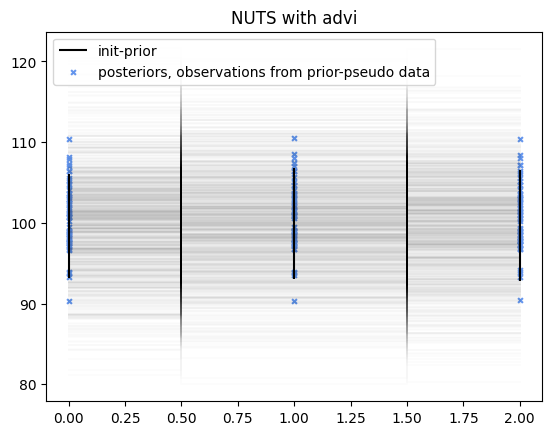

In [122]:

# init Prior
plt.step(np.linspace(0,nBins-1,nBins),prior_pred_init.prior_predictive.ExpData1[0].T, alpha = 0.01, c = 'black', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred_init.prior_predictive.ExpData1[0],[.15,.85],axis=0), colors = 'black', label='init-prior');

# iiterative Prior
# plt.step(np.linspace(0,nBins-1,nBins),prior_pred_1.prior_predictive.ExpData1[0].T, alpha = 0.01, c = 'green', where = 'mid');
# plt.vlines(np.arange(nBins),*np.quantile(prior_pred_1.prior_predictive.ExpData1[0],[.15,.85],axis=0), colors = 'green', label='prior after 1 iteration');

plt.scatter(np.arange(nBins), post_averages[1], color = 'cornflowerblue', s=12, marker='x', label='posteriors, observations from prior-pseudo data')

for i in np.linspace(1, int(iterations-1), int(iterations-1), dtype=int):
    ii = randint(0, n_samples-1)
    plt.scatter(np.arange(nBins), post_averages[i], color = 'cornflowerblue', marker='x', s=12)#, label='posterior after 1 iteration')

# Observations
# plt.scatter(np.arange(nBins), init_obs, c = 'grey', s=12, zorder = 999, label = "init-data")

plt.title('NUTS with advi')
plt.legend(loc='upper left')

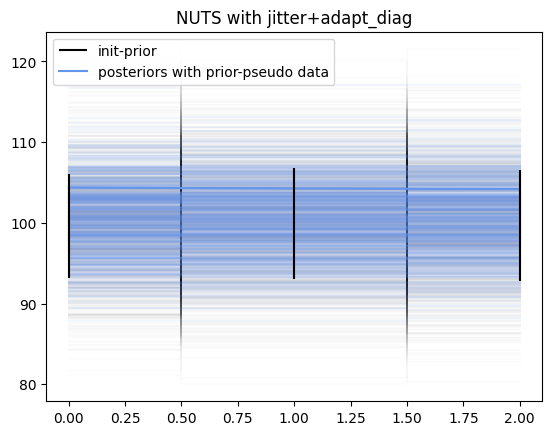

In [150]:

# init Prior
plt.step(np.linspace(0,nBins-1,nBins),prior_pred_init.prior_predictive.ExpData1[0].T, alpha = 0.01, c = 'black', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred_init.prior_predictive.ExpData1[0],[.15,.85],axis=0), colors = 'black', label='init-prior', zorder=1900);

# iiterative Prior
# plt.step(np.linspace(0,nBins-1,nBins),prior_pred_1.prior_predictive.ExpData1[0].T, alpha = 0.01, c = 'green', where = 'mid');
# plt.vlines(np.arange(nBins),*np.quantile(prior_pred_1.prior_predictive.ExpData1[0],[.15,.85],axis=0), colors = 'green', label='prior after 1 iteration');

plt.plot(np.arange(nBins), post_averages[1], color = 'cornflowerblue', label='posteriors with prior-pseudo data')

for i in np.linspace(1, int(iterations-1), int(iterations-1), dtype=int):
    plt.step(np.linspace(0,nBins-1,nBins),np.asarray(post_averages[i]).T, alpha = 0.08, c = 'cornflowerblue', where = 'mid');



# Observations
# plt.scatter(np.arange(nBins), init_obs, c = 'grey', s=12, zorder = 999, label = "init-data")

plt.title('NUTS with jitter+adapt_diag')
plt.legend(loc='upper left')

#### RANDOM, ignore

In [222]:
N = 3
nBins = N
init_obs = jnp.array([700., 700, 700.])# 90., 90., 80.])
model = pyhf.simplemodels.correlated_background([10]*N,[50]*N, [45]*N, [55]*N)

n_samples = 5000

unconstr_dict = {
    'mu': {'type': 'unconstrained', 'input': [[500.], [100.]]}
}
prior_dict = prepare_inference.prepare_priors(model, unconstr_dict)
prepared_model = prepare_inference.prepare_model(model=model, observations=init_obs, precision=4, priors=prior_dict)

Sampling 1 chain for 1_000 tune and 5_000 draw iterations (1_000 + 5_000 draws total) took 1 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


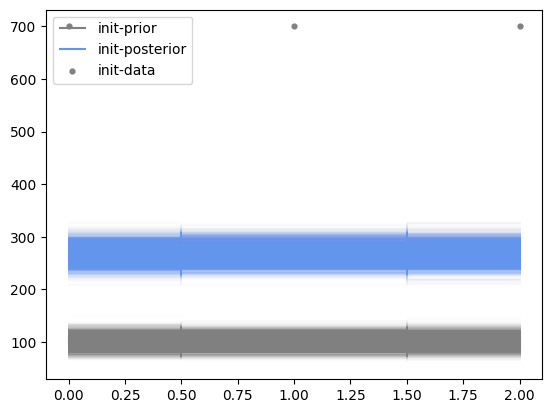

In [223]:
# init prior and posteriors
with pm.Model() as m1:
    # pars1 = pm.Deterministic('pars1', prepare_inference.priors2pymc(prepared_model))
    pars1 = prepare_inference.priors2pymc(prepared_model)
    # ExpData_Det1 = pm.Deterministic('ExpData_Det1', expData_op(pars1))

    ExpData1 = pm.Poisson("ExpData1", mu=expData_op(pars1), observed=init_obs)
    
    step1 = pm.Metropolis()
    
    post_data_init = pm.sample(n_samples, chains=1, cores=4, step=step1)
    post_pred_init = pm.sample_posterior_predictive(post_data_init)
    prior_pred_init = pm.sample_prior_predictive(n_samples)

# init Prior
plt.step(np.linspace(0,nBins-1,nBins),prior_pred_init.prior_predictive.ExpData1[0].T, alpha = 0.01, c = 'grey', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred_init.prior_predictive.ExpData1[0],[.15,.85],axis=0), colors = 'grey', label='init-prior');

# init Posterior
plt.step(np.linspace(0,nBins-1,nBins),post_pred_init.posterior_predictive.ExpData1[0].T, alpha = 0.01, c = 'cornflowerblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred_init.posterior_predictive.ExpData1[0],[.15,.85],axis=0), colors = 'cornflowerblue', label='init-posterior')

# Observations
plt.scatter(np.arange(nBins), init_obs, c = 'grey', s=12, zorder = 999, label = "init-data")


plt.legend(loc='upper left')

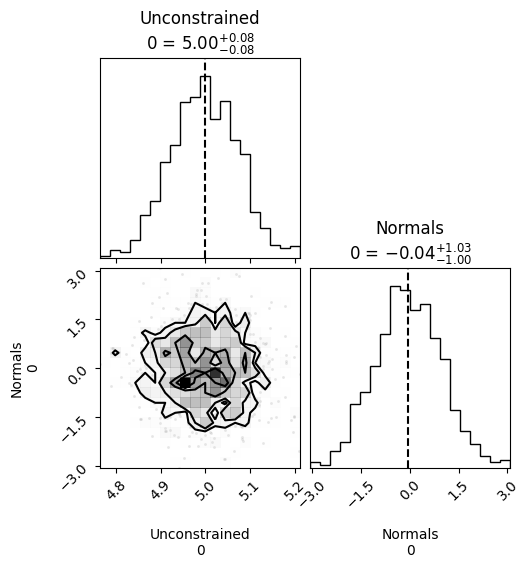

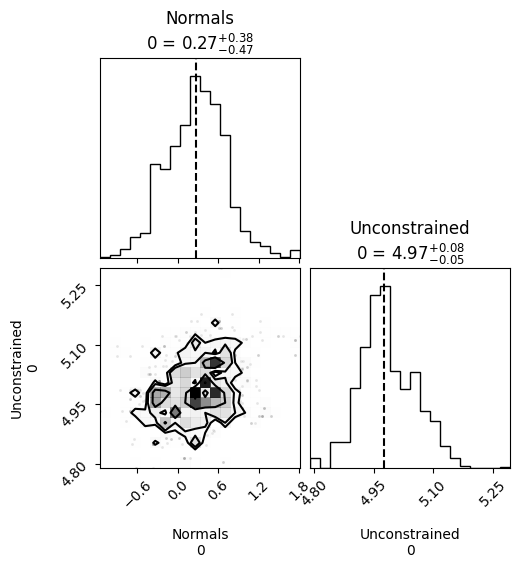

In [225]:
a = corner.corner(prior_pred.prior, quantiles=[0.5], show_titles=True)
corner.corner(post_data.posterior, quantiles=[0.5], show_titles=True);

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


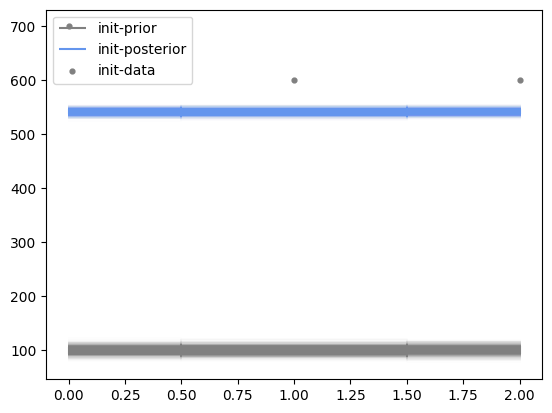

In [89]:
# init prior and posteriors
with pm.Model() as m1:
    # pars1 = pm.Deterministic('pars1', prepare_inference.priors2pymc(prepared_model))
    pars1 = prepare_inference.priors2pymc(prepared_model)
    # ExpData_Det1 = pm.Deterministic('ExpData_Det1', expData_op(pars1))

    ExpData1 = pm.Normal("ExpData1", mu=expData_op(pars1), sigma = 4, observed=init_obs)
    
    step1 = pm.Metropolis()
    
    post_data_init = pm.sample(n_samples, chains=1, cores=4, init='advi')
    post_pred_init = pm.sample_posterior_predictive(post_data_init)
    prior_pred_init = pm.sample_prior_predictive(n_samples)

# init Prior
plt.step(np.linspace(0,nBins-1,nBins),prior_pred_init.prior_predictive.ExpData1[0].T, alpha = 0.01, c = 'grey', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred_init.prior_predictive.ExpData1[0],[.15,.85],axis=0), colors = 'grey', label='init-prior');

# init Posterior
plt.step(np.linspace(0,nBins-1,nBins),post_pred_init.posterior_predictive.ExpData1[0].T, alpha = 0.01, c = 'cornflowerblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred_init.posterior_predictive.ExpData1[0],[.15,.85],axis=0), colors = 'cornflowerblue', label='init-posterior')

# Observations
plt.scatter(np.arange(nBins), init_obs, c = 'grey', s=12, zorder = 999, label = "init-data")


plt.legend(loc='upper left')

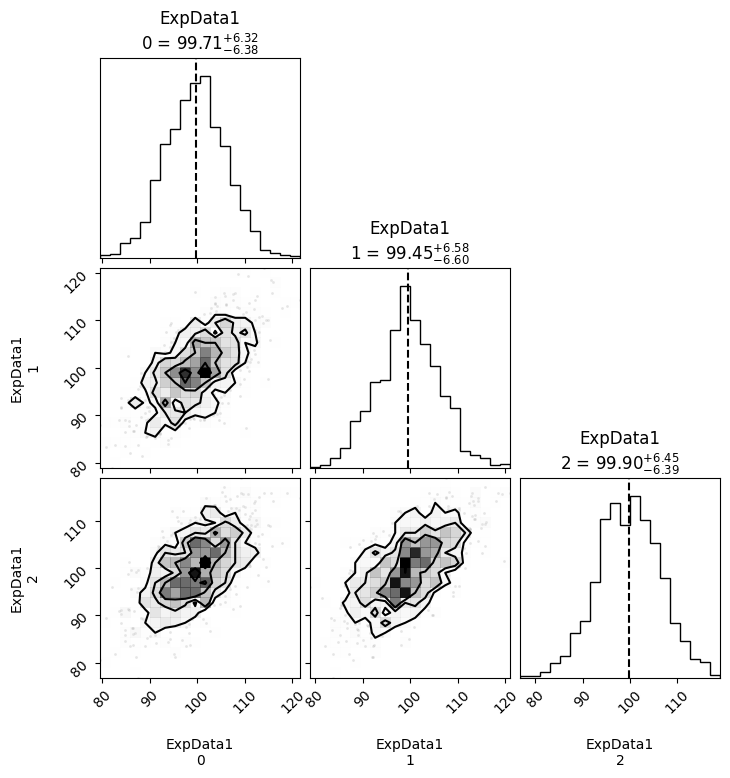

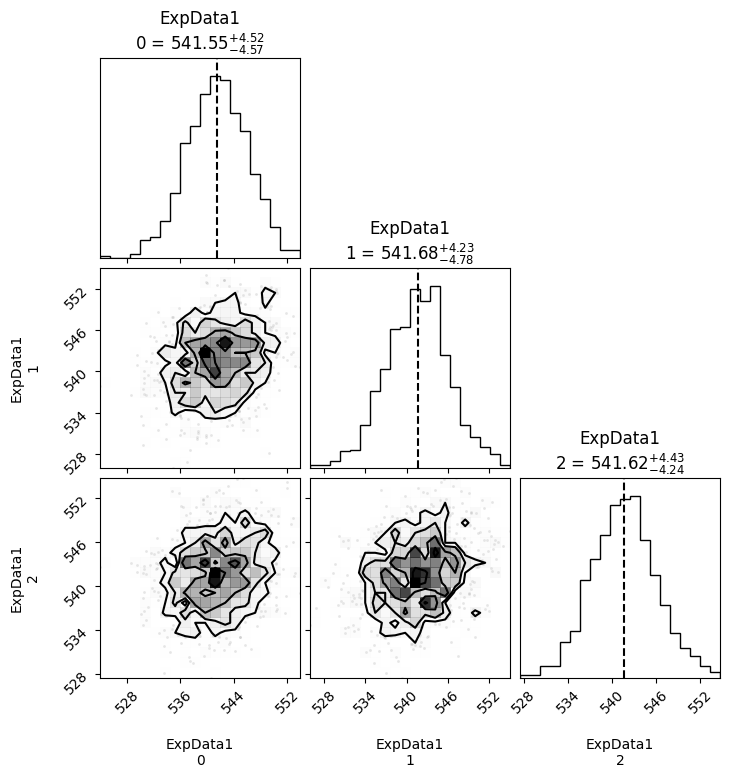

In [90]:
a = corner.corner(prior_pred_init.prior_predictive, quantiles=[0.5], show_titles=True)
b = corner.corner(post_pred_init.posterior_predictive, quantiles=[0.5], show_titles=True)

#### Iterations with averaging

In [ ]:
obs_from_prior = init_obs

n_samples = 100
n_iterations = 3

post = []
post_average_iters = []

for iterations in np.linspace(1, 25, n_iterations, dtype=int):
    obs_from_prior = init_obs
    print(f'ITERATION: {iterations}')
    for i in range(iterations):
        with pm.Model() as m1:
            # pars1 = pm.Deterministic('pars1', prepare_inference.priors2pymc(prepared_model))
            pars1 = prepare_inference.priors2pymc(prepared_model)
            
            # ExpData_Det1 = pm.Deterministic('ExpData_Det1', expData_op(pars1))
            ExpData1 = pm.Normal("ExpData1", mu=expData_op(pars1), sigma = 8, observed=obs_from_prior)
            
            step1 = pm.Metropolis()
            
            post_data = pm.sample(n_samples, chains=1, cores=4)#, step=step1)
            post_pred = pm.sample_posterior_predictive(post_data)
            prior_pred = pm.sample_prior_predictive(n_samples)

            post.append(post_pred.posterior_predictive.ExpData1[0])

            ii = randint(0, n_samples - 1)
            print(f'ii: {ii} for i: {i}')
            obs_from_prior = prior_pred.prior_predictive.ExpData1[0][ii] 
        
    post_average = []
    for i in range(nBins):
        aa = 0
        for b in range(n_samples):
            for a in range(iterations):
                aa = aa + post[a][b][i]
        post_average.append(aa/(n_samples*iterations))

    post_average_iters.append(np.asarray(post_average))

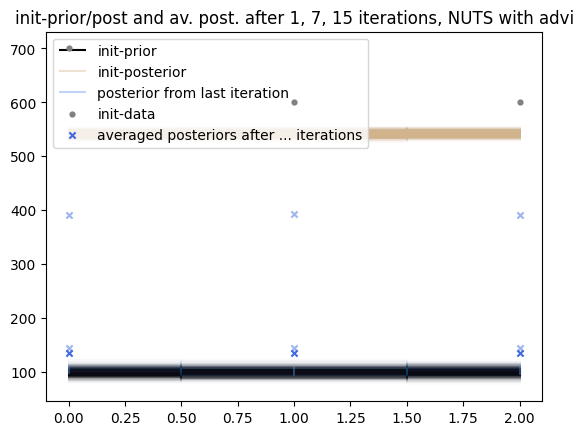

In [96]:
# init Prior
plt.step(np.linspace(0,nBins-1,nBins),prior_pred_init.prior_predictive.ExpData1[0].T, alpha = 0.01, c = 'black', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred_init.prior_predictive.ExpData1[0],[.15,.85],axis=0), colors = 'black', label='init-prior');

# init Posterior
plt.step(np.linspace(0,nBins-1,nBins),post_pred_init.posterior_predictive.ExpData1[0].T, alpha = 0.02, c = 'tan', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred_init.posterior_predictive.ExpData1[0],[.15,.85],axis=0), alpha = 0.4, colors = 'tan', label='init-posterior')

# Posterior from last iteration
plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.ExpData1[0].T, alpha = 0.01, c = 'cornflowerblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.ExpData1[0],[.15,.85],axis=0),colors = 'cornflowerblue', alpha=0.4, label='posterior from last iteration')

# Observations
plt.scatter(np.arange(nBins), init_obs, c = 'grey', s=12, zorder = 999, label = "init-data")

# Average posterior
plt.scatter(np.arange(nBins), post_average_iters[n_iterations-1], c = 'royalblue', s=20, marker='x', zorder = 999, alpha = 1, label = 'averaged posteriors after ... iterations')
for i in range(n_iterations-1):
    plt.scatter(np.arange(nBins), post_average_iters[i], c = 'royalblue', s=20, marker='x', zorder = 999, alpha = i/1000+0.5)

plt.legend(loc='upper left')
plt.title(f'init-prior/post and av. post. after 1, 7, 15 iterations, NUTS with advi')

# plt.savefig('Metropolis_1_and_100_iterations.pdf')
plt.show()

#### Iterations w/o averaging

In [97]:
obs_from_prior = init_obs
iterations = 1
post = []

for i in range(iterations):
    with pm.Model() as m1:
        pars1 = prepare_inference.priors2pymc(prepared_model)

        ExpData1 = pm.Normal("ExpData1", mu=expData_op(pars1), sigma = 4, observed=obs_from_prior)
        
        step1 = pm.Metropolis()
        
        post_data_1 = pm.sample(n_samples, chains=1, cores=4, step=step1)
        post_pred_1 = pm.sample_posterior_predictive(post_data_1)
        prior_pred_1 = pm.sample_prior_predictive(n_samples)

        ii = randint(0, n_samples - 1)
        print(f'ii: {ii} for i: {i}')
        obs_from_prior = prior_pred.prior_predictive.ExpData1[0][ii] 

Only 100 samples in chain.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 68 for i: 0


In [98]:
obs_from_prior = init_obs
iterations = 2
post = []

for i in range(iterations):
    with pm.Model() as m1:
        pars1 = prepare_inference.priors2pymc(prepared_model)

        ExpData1 = pm.Normal("ExpData1", mu=expData_op(pars1), sigma = 4, observed=obs_from_prior)
        
        step1 = pm.Metropolis()
        
        post_data_2 = pm.sample(n_samples, chains=1, cores=4, step=step1)
        post_pred_2 = pm.sample_posterior_predictive(post_data_2)
        prior_pred_2 = pm.sample_prior_predictive(n_samples)

        post.append(post_pred.posterior_predictive.ExpData1[0])

        ii = randint(0, n_samples - 1)
        print(f'ii: {ii} for i: {i}')
        obs_from_prior = prior_pred.prior_predictive.ExpData1[0][ii] 

Only 100 samples in chain.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 15 for i: 0


Only 100 samples in chain.


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 55 for i: 1


In [99]:
obs_from_prior = init_obs
iterations = 3
post = []

for i in range(iterations):
    with pm.Model() as m1:
        pars1 = prepare_inference.priors2pymc(prepared_model)

        ExpData1 = pm.Normal("ExpData1", mu=expData_op(pars1), sigma = 4, observed=obs_from_prior)
        
        step1 = pm.Metropolis()
        
        post_data_3 = pm.sample(n_samples, chains=1, cores=4, step=step1)
        post_pred_3 = pm.sample_posterior_predictive(post_data_3)
        prior_pred_3 = pm.sample_prior_predictive(n_samples)


        ii = randint(0, n_samples - 1)
        print(f'ii: {ii} for i: {i}')
        obs_from_prior = prior_pred.prior_predictive.ExpData1[0][ii] 

Only 100 samples in chain.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 2 for i: 0


Only 100 samples in chain.


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 28 for i: 1


Only 100 samples in chain.


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 68 for i: 2


In [ ]:
obs_from_prior = init_obs
iterations = 10
post = []

for i in range(iterations):
    with pm.Model() as m1:
        pars1 = prepare_inference.priors2pymc(prepared_model)

        ExpData1 = pm.Normal("ExpData1", mu=expData_op(pars1), sigma = 4, observed=obs_from_prior)
        
        step1 = pm.Metropolis()
        
        post_data_10 = pm.sample(n_samples, chains=1, cores=4, step=step1)
        post_pred_10 = pm.sample_posterior_predictive(post_data_10)
        prior_pred_10 = pm.sample_prior_predictive(n_samples)


        ii = randint(0, n_samples - 1)
        print(f'ii: {ii} for i: {i}')
        obs_from_prior = prior_pred.prior_predictive.ExpData1[0][ii] 

In [ ]:
obs_from_prior = init_obs
iterations = 15
post = []

for i in range(iterations):
    with pm.Model() as m1:
        pars1 = prepare_inference.priors2pymc(prepared_model)

        ExpData1 = pm.Normal("ExpData1", mu=expData_op(pars1), sigma = 4, observed=obs_from_prior)
        
        step1 = pm.Metropolis()
        
        post_data_15 = pm.sample(n_samples, chains=1, cores=4, step=step1)
        post_pred_15 = pm.sample_posterior_predictive(post_data_15)
        prior_pred_15 = pm.sample_prior_predictive(n_samples)


        ii = randint(0, n_samples - 1)
        print(f'ii: {ii} for i: {i}')
        obs_from_prior = prior_pred.prior_predictive.ExpData1[0][ii] 

In [101]:
post_average_1 = []
aa = 0
for i in range(nBins):
    aa = 0
    for ii in range(n_samples):
        # print(post_pred_1.posterior_predictive.ExpData1[0][ii][i])
        aa = aa + post_pred_1.posterior_predictive.ExpData1[0][ii][i]
    post_average_1.append(aa/n_samples)

post_average_2 = []
aa = 0
for i in range(nBins):
    aa = 0
    for ii in range(n_samples):
        # print(post_pred_1.posterior_predictive.ExpData1[0][ii][i])
        aa = aa + post_pred_2.posterior_predictive.ExpData1[0][ii][i]
    post_average_2.append(aa/n_samples)


post_average_3 = []
aa = 0
for i in range(nBins):
    aa = 0
    for ii in range(n_samples):
        # print(post_pred_1.posterior_predictive.ExpData1[0][ii][i])
        aa = aa + post_pred_3.posterior_predictive.ExpData1[0][ii][i]
    post_average_3.append(aa/n_samples)

post_average_10 = []
aa = 0
for i in range(nBins):
    aa = 0
    for ii in range(n_samples):
        # print(post_pred_1.posterior_predictive.ExpData1[0][ii][i])
        aa = aa + post_pred_10.posterior_predictive.ExpData1[0][ii][i]
    post_average_10.append(aa/n_samples)


# post_average_15 = []
# aa = 0
# for i in range(nBins):
#     aa = 0
#     for ii in range(n_samples):
#         # print(post_pred_1.posterior_predictive.ExpData1[0][ii][i])
#         aa = aa + post_pred_15.posterior_predictive.ExpData1[0][ii][i]
    # post_average_15.append(aa/n_samples)

# post_average_20 = []
# aa = 0
# for i in range(nBins):
#     aa = 0
#     for ii in range(n_samples):
#         # print(post_pred_1.posterior_predictive.ExpData1[0][ii][i])
#         aa = aa + post_pred_20.posterior_predictive.ExpData1[0][ii][i]
#     post_average_20.append(aa/n_samples)

print(np.asarray(post_average_1))
print(np.asarray(post_average_3))
print(np.asarray(post_average_10))
# print(np.asarray(post_average_15))
# print(np.asarray(post_average_20))

[541.68272278 541.18356818 540.55596089]
[112.60568994 111.61163179 111.42571886]
[97.68704758 97.6331254  97.18823551]


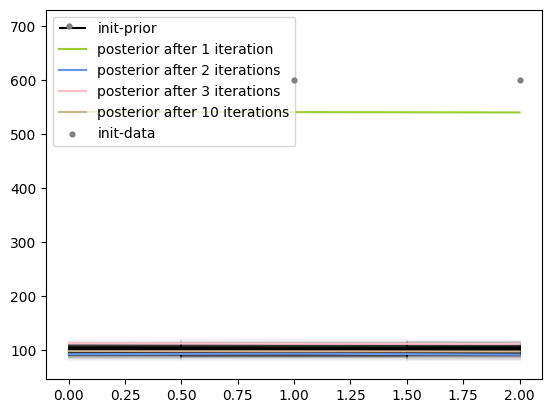

In [103]:
# init Prior
plt.step(np.linspace(0,nBins-1,nBins),prior_pred_init.prior_predictive.ExpData1[0].T, alpha = 0.01, c = 'black', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred_init.prior_predictive.ExpData1[0],[.15,.85],axis=0), colors = 'black', label='init-prior');

# iiterative Prior
# plt.step(np.linspace(0,nBins-1,nBins),prior_pred_1.prior_predictive.ExpData1[0].T, alpha = 0.01, c = 'green', where = 'mid');
# plt.vlines(np.arange(nBins),*np.quantile(prior_pred_1.prior_predictive.ExpData1[0],[.15,.85],axis=0), colors = 'green', label='prior after 1 iteration');

plt.plot(np.arange(nBins), post_average_1, color = 'yellowgreen', label='posterior after 1 iteration')
plt.plot(np.arange(nBins), post_average_2, color = 'cornflowerblue', label='posterior after 2 iterations')
plt.plot(np.arange(nBins), post_average_3, color = 'pink', label='posterior after 3 iterations')
plt.plot(np.arange(nBins), post_average_10, color = 'tan', label='posterior after 10 iterations')
# plt.plot(np.arange(nBins), post_average_15, color = 'orange', label='posterior after 15 iterations')
# plt.plot(np.arange(nBins), post_average_20, color = 'pink', label='posterior after 20 iterations')


# Observations
plt.scatter(np.arange(nBins), init_obs, c = 'grey', s=12, zorder = 999, label = "init-data")


plt.legend(loc='upper left')

# Autocorrelation

In [128]:
N = 3
nBins = N
init_obs = jnp.array([70., 60., 60.])# 90., 90., 80.])
model = pyhf.simplemodels.correlated_background([10]*N,[50]*N, [45]*N, [55]*N)
model.expected_actualdata(model.config.suggested_init()),model.config.suggested_init()

n_samples = 10_000

unconstr_dict = {
    'mu': {'type': 'unconstrained', 'input': [[5000.], [1000.]]}
}
prior_dict = prepare_inference.prepare_priors(model, unconstr_dict)
prepared_model = prepare_inference.prepare_model(model=model, observations=init_obs, precision=4, priors=prior_dict)

#### NUTS advi

In [142]:
n_samples = 1000

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


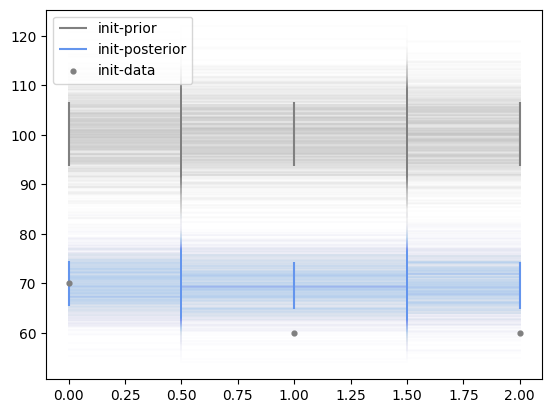

In [143]:
# init prior and posteriors
with pm.Model() as m1:
    # pars1 = pm.Deterministic('pars1', prepare_inference.priors2pymc(prepared_model))
    pars1 = prepare_inference.priors2pymc(prepared_model)
    # ExpData_Det1 = pm.Deterministic('ExpData_Det1', expData_op(pars1))

    ExpData1 = pm.Normal("ExpData1", mu=expData_op(pars1), sigma = 4, observed=init_obs)
    
    step1 = pm.Metropolis()
    
    post_data_init = pm.sample(n_samples, chains=1, cores=4)
    post_pred_init = pm.sample_posterior_predictive(post_data_init)
    prior_pred_init = pm.sample_prior_predictive(n_samples)

# init Prior
plt.step(np.linspace(0,nBins-1,nBins),prior_pred_init.prior_predictive.ExpData1[0].T, alpha = 0.01, c = 'grey', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred_init.prior_predictive.ExpData1[0],[.15,.85],axis=0), colors = 'grey', label='init-prior');

# init Posterior
plt.step(np.linspace(0,nBins-1,nBins),post_pred_init.posterior_predictive.ExpData1[0].T, alpha = 0.01, c = 'cornflowerblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred_init.posterior_predictive.ExpData1[0],[.15,.85],axis=0), colors = 'cornflowerblue', label='init-posterior')

# Observations
plt.scatter(np.arange(nBins), init_obs, c = 'grey', s=12, zorder = 999, label = "init-data")


plt.legend(loc='upper left')

array([[<AxesSubplot: title={'center': 'Normals'}>,
        <AxesSubplot: title={'center': 'Normals'}>],
       [<AxesSubplot: title={'center': 'Unconstrained'}>,
        <AxesSubplot: title={'center': 'Unconstrained'}>]], dtype=object)

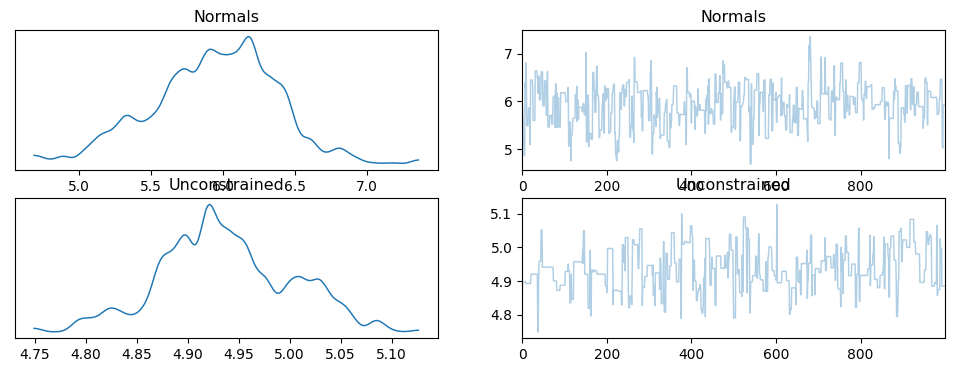

In [144]:
az.plot_trace(post_data_init)


array([<AxesSubplot: title={'center': 'Normals\n0, 0'}>,
       <AxesSubplot: title={'center': 'Unconstrained\n0, 0'}>],
      dtype=object)

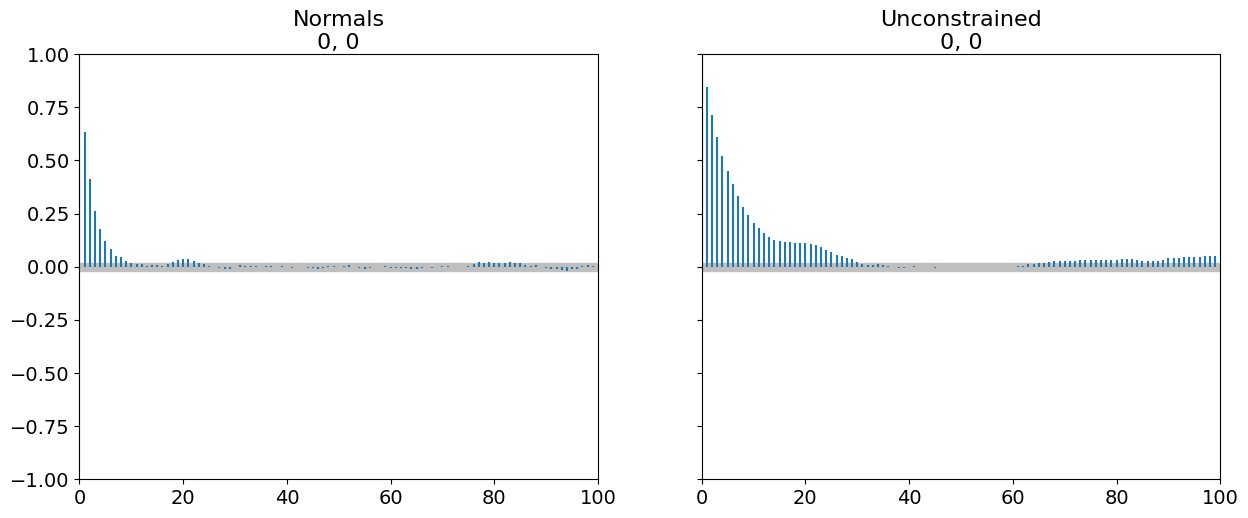

In [141]:
az.plot_autocorr(post_data_init)